# This notebook contains attempts to get higher-order effective energy and z-values by subtracting out lower-order states one by one

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import gvar as gv

In [20]:
import h5py
import lsqfit
import h5data_methods as h5_dm

In [21]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885

# Plot constants
t_min_plt = 1
t_max_plt = 25

t_plot = np.array([i for i in range(t_min_plt, t_max_plt)])

In [22]:
# Load the data
data = gv.BufferDict()
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]

gv_avg_data = gv.dataset.avg_data(data)

In [23]:
# calculate and load in the effective masses into the gv_avg_data array

gv_avg_data['E0_eff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['E0_eff_SS'] = np.log(gv_avg_data['2pt_SS'] / np.roll(gv_avg_data['2pt_SS'], -1, axis=0))
gv_avg_data['E0_eff_PS'] = np.log(gv_avg_data['2pt_PS'] / np.roll(gv_avg_data['2pt_PS'], -1, axis=0))

gv_avg_data['zS0_eff'] = np.array([np.sqrt(np.exp(gv_avg_data['E0_eff_SS'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['zP0_eff'] = np.array([np.exp(gv_avg_data['E0_eff_PS'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['zS0_eff'][t] for t in range(63)])


<ipython-input-23-f9b14eaa0810>:3: RuntimeWarning: invalid value encountered in log
  gv_avg_data['E0_eff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-23-f9b14eaa0810>:4: RuntimeWarning: invalid value encountered in log
  gv_avg_data['E0_eff_SS'] = np.log(gv_avg_data['2pt_SS'] / np.roll(gv_avg_data['2pt_SS'], -1, axis=0))
<ipython-input-23-f9b14eaa0810>:5: RuntimeWarning: invalid value encountered in log
  gv_avg_data['E0_eff_PS'] = np.log(gv_avg_data['2pt_PS'] / np.roll(gv_avg_data['2pt_PS'], -1, axis=0))
<ipython-input-23-f9b14eaa0810>:7: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['zS0_eff'] = np.array([np.sqrt(np.exp(gv_avg_data['E0_eff_SS'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


In [24]:
# Find the first excited state correlation function
# Methodology #1: use the ground-state fit-priors to obtain a ground state "correlation function" to subtract from the actual correlation function to get the excited correlation function
priors = gv.BufferDict()
priors['E0'] = gv.gvar(0.67, 0.02)
priors['Z0'] = gv.gvar(0.00078, 0.00005)
priors['Ztilde0'] = gv.gvar(0.003, 0.0003)

gv_avg_data['2pt_priorbased_1_SS'] = np.array([gv_avg_data['2pt_SS'][t] - priors['Z0']**2 * np.exp(-t*priors['E0']) for t in range(63)])
gv_avg_data['2pt_priorbased_1_PS'] = np.array([gv_avg_data['2pt_SS'][t] - priors['Z0']* priors['Ztilde0'] * np.exp(-t*priors['E0']) for t in range(63)])

gv_avg_data['E1_priorbased_SS'] = np.log(gv_avg_data['2pt_priorbased_1_SS']/np.roll(gv_avg_data['2pt_priorbased_1_SS'], -1, axis = 0))
gv_avg_data['E1_priorbased_PS'] = np.log(gv_avg_data['2pt_priorbased_1_PS']/np.roll(gv_avg_data['2pt_priorbased_1_PS'], -1, axis = 0))

gv_avg_data['zS1_priorbased'] = np.array([np.sqrt(np.exp(gv_avg_data['E1_priorbased_SS'][t]*t)*gv_avg_data['2pt_priorbased_1_SS'][t]) for t in range(63)])
gv_avg_data['zP1_priorbased'] = np.array([np.exp(gv_avg_data['E1_priorbased_PS'][t]*t)*gv_avg_data['2pt_priorbased_1_PS'][t]/gv_avg_data['zS1_priorbased'][t] for t in range(63)])

# Methodology #2: take an average over the flat region in E0eff, ZSeff, and ZPeff, then from the correlation function
# subtract the predicted ground state contribution
# Do it for two cases: where you obtain the averaged Meff separately for SS and PS

t_range = np.arange(9,17,1)
print(gv_avg_data['E0_eff_SS'][t_range])
print(gv_avg_data['E0_eff_SS'][t_range] - np.array([gv_avg_data['E0_eff_SS'][t_range][i].sdev for i in range(len(gv_avg_data['E0_eff_SS'][t_range]))]))
print(t_range)
print(np.sum(gv_avg_data['E0_eff_SS'][t_range]))
print(np.sum(gv_avg_data['E0_eff_SS'][t_range])/len(t_range))
print(np.sum(gv_avg_data['E0_eff_SS'][t_range] - np.array([gv_avg_data['E0_eff_SS'][t_range][i].sdev for i in range(len(gv_avg_data['E0_eff_SS'][t_range]))]))/len(t_range))

gv_avg_data['E0eff_SS_avg'] = np.sum(gv_avg_data['E0_eff_SS'][t_range])/len(t_range) # - np.array([gv_avg_data['E0_eff_SS'][t_range][i].sdev for i in range(len(gv_avg_data['E0_eff_SS'][t_range]))])
gv_avg_data['E0eff_PS_avg'] = np.sum(gv_avg_data['E0_eff_PS'][t_range])/len(t_range) #  - np.array([gv_avg_data['E0_eff_PS'][t_range][i].sdev for i in range(len(gv_avg_data['E0_eff_PS'][t_range]))])
gv_avg_data['E0eff_avg'] = (np.sum(gv_avg_data['E0_eff_SS'][t_range]) + np.sum(gv_avg_data['E0_eff_PS'][t_range]))/(2*len(t_range))

gv_avg_data['zS0eff_avg'] = np.sum(gv_avg_data['zS0_eff'][t_range])/len(t_range) # - np.array([gv_avg_data['zS0_eff'][t_range][i].sdev for i in range(len(gv_avg_data['zS0_eff'][t_range]))])
gv_avg_data['zP0eff_avg'] = np.sum(gv_avg_data['zP0_eff'][t_range])/len(t_range) # - np.array([gv_avg_data['zP0_eff'][t_range][i].sdev for i in range(len(gv_avg_data['zP0_eff'][t_range]))])

gv_avg_data['2pt_1_SS'] = np.array([gv_avg_data['2pt_SS'][t] - gv_avg_data['zS0eff_avg']**2 * np.exp(-t*gv_avg_data['E0eff_SS_avg']) for t in range(63)])
gv_avg_data['2pt_1_PS'] = np.array([gv_avg_data['2pt_PS'][t] - gv_avg_data['zS0eff_avg']*gv_avg_data['zP0eff_avg'] * np.exp(-t*gv_avg_data['E0eff_PS_avg']) for t in range(63)])
gv_avg_data['2pt_1_combined_SS'] = np.array([gv_avg_data['2pt_SS'][t] - gv_avg_data['zS0eff_avg']**2 * np.exp(-t*gv_avg_data['E0eff_avg']) for t in range(63)])
gv_avg_data['2pt_1_combined_PS'] = np.array([gv_avg_data['2pt_PS'][t] - gv_avg_data['zS0eff_avg']*gv_avg_data['zP0eff_avg'] * np.exp(-t*gv_avg_data['E0eff_avg']) for t in range(63)])

#print(gv_avg_data['2pt_1_SS'])
#print(gv_avg_data['2pt_1_PS'])

gv_avg_data['E1_eff_SS'] = np.log(gv_avg_data['2pt_1_SS']/np.roll(gv_avg_data['2pt_1_SS'], -1, axis = 0))
gv_avg_data['E1_eff_PS'] = np.log(gv_avg_data['2pt_1_PS']/np.roll(gv_avg_data['2pt_1_PS'], -1, axis = 0))
gv_avg_data['E1_eff_combined_SS'] = np.log(gv_avg_data['2pt_1_combined_SS']/np.roll(gv_avg_data['2pt_1_combined_SS'], -1, axis = 0))
gv_avg_data['E1_eff_combined_PS'] = np.log(gv_avg_data['2pt_1_combined_PS']/np.roll(gv_avg_data['2pt_1_combined_PS'], -1, axis = 0))


gv_avg_data['zS1_eff'] = np.array([np.sqrt(np.exp(gv_avg_data['E1_eff_SS'][t]*t)*gv_avg_data['2pt_1_SS'][t]) for t in range(63)])
gv_avg_data['zP1_eff'] = np.array([np.exp(gv_avg_data['E1_eff_PS'][t]*t)*gv_avg_data['2pt_1_PS'][t]/gv_avg_data['zS1_eff'][t] for t in range(63)])
gv_avg_data['zS1_eff_combined'] = np.array([np.sqrt(np.exp(gv_avg_data['E1_eff_combined_SS'][t]*t)*gv_avg_data['2pt_1_combined_SS'][t]) for t in range(63)])
gv_avg_data['zP1_eff_combined'] = np.array([np.exp(gv_avg_data['E1_eff_combined_PS'][t]*t)*gv_avg_data['2pt_1_combined_PS'][t]/gv_avg_data['zS1_eff_combined'][t] for t in range(63)])

[0.6653(25) 0.6635(34) 0.6648(46) 0.6665(64) 0.6568(89) 0.643(13)
 0.631(18) 0.631(24)]
[0.6628(25) 0.6601(34) 0.6602(46) 0.6600(64) 0.6479(89) 0.631(13)
 0.613(18) 0.607(24)]
[ 9 10 11 12 13 14 15 16]
5.222(57)
0.6527(72)
0.6427(72)


<ipython-input-24-b64a291aea9a>:11: RuntimeWarning: invalid value encountered in log
  gv_avg_data['E1_priorbased_SS'] = np.log(gv_avg_data['2pt_priorbased_1_SS']/np.roll(gv_avg_data['2pt_priorbased_1_SS'], -1, axis = 0))
<ipython-input-24-b64a291aea9a>:12: RuntimeWarning: invalid value encountered in log
  gv_avg_data['E1_priorbased_PS'] = np.log(gv_avg_data['2pt_priorbased_1_PS']/np.roll(gv_avg_data['2pt_priorbased_1_PS'], -1, axis = 0))
<ipython-input-24-b64a291aea9a>:14: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['zS1_priorbased'] = np.array([np.sqrt(np.exp(gv_avg_data['E1_priorbased_SS'][t]*t)*gv_avg_data['2pt_priorbased_1_SS'][t]) for t in range(63)])
<ipython-input-24-b64a291aea9a>:44: RuntimeWarning: invalid value encountered in log
  gv_avg_data['E1_eff_SS'] = np.log(gv_avg_data['2pt_1_SS']/np.roll(gv_avg_data['2pt_1_SS'], -1, axis = 0))
<ipython-input-24-b64a291aea9a>:45: RuntimeWarning: invalid value encountered in log
  gv_avg_data['E1_eff_PS'] = np.log

In [25]:
# Average and state the effective first excited state energies and z-factors
t_excited_range = np.arange(5,8,1)
gv_avg_data['E1_eff_SS_avg'] = np.sum(gv_avg_data['E1_eff_combined_SS'][t_excited_range])/len(t_excited_range)
gv_avg_data['E1_eff_PS_avg'] = np.sum(gv_avg_data['E1_eff_combined_PS'][t_excited_range])/len(t_excited_range)
gv_avg_data['E1_eff_avg'] = (np.sum(gv_avg_data['E1_eff_combined_SS'][t_excited_range]) + np.sum(gv_avg_data['E1_eff_PS'][t_excited_range]))/(2*len(t_excited_range))

gv_avg_data['zS1_eff_avg'] = np.sum(gv_avg_data['zS1_eff_combined'][t_excited_range])/len(t_excited_range)
gv_avg_data['zP1_eff_avg'] = np.sum(gv_avg_data['zP1_eff_combined'][t_excited_range])/len(t_excited_range)

print("Excited state priors: E1: ", gv_avg_data['E1_eff_avg'], "; zS1: ", gv_avg_data['zS1_eff_avg'], "; zP1: ", gv_avg_data['zP1_eff_avg'])

# Use those to estimate the second excited state

Excited state priors: E1:  0.986(58) ; zS1:  0.000607(61) ; zP1:  0.0049(14)


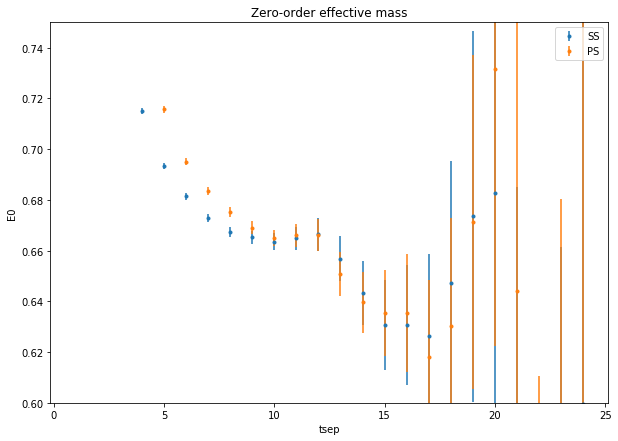

<Figure size 432x288 with 0 Axes>

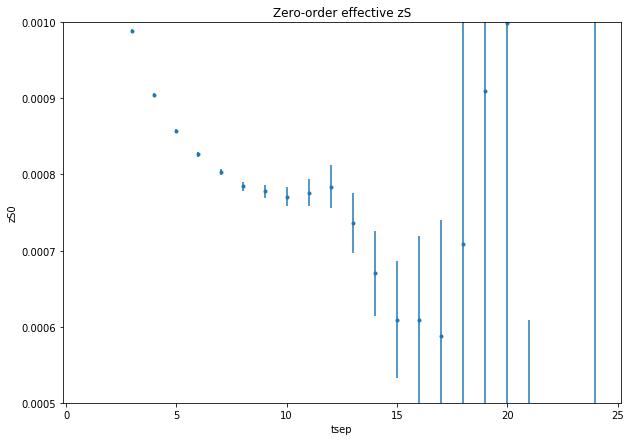

<Figure size 432x288 with 0 Axes>

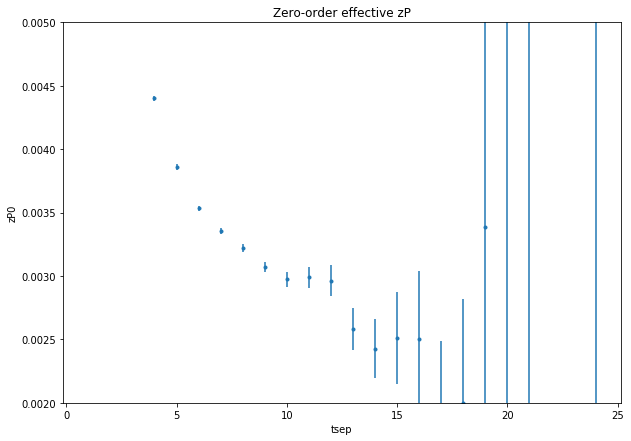

<Figure size 432x288 with 0 Axes>

In [26]:
# Plot E0eff, zS0eff, zP0eff

E0_eff_SS_mean = np.array([gv_avg_data['E0_eff_SS'][i].mean for i in t_plot])
E0_eff_SS_sdev = np.array([gv_avg_data['E0_eff_SS'][i].sdev for i in t_plot])
E0_eff_PS_mean = np.array([gv_avg_data['E0_eff_PS'][i].mean for i in t_plot])
E0_eff_PS_sdev = np.array([gv_avg_data['E0_eff_PS'][i].sdev for i in t_plot])

meff_labels = np.array(['SS', 'PS'])
h5_dm.raw_data_plot("Zero-order effective mass", "tsep", "E0", [t_plot, t_plot], [E0_eff_SS_mean, E0_eff_PS_mean], ylim=[0.6, 0.75], nplots = 2, yerror = [E0_eff_SS_sdev, E0_eff_PS_sdev], legendlabels = meff_labels)

zS0_eff_mean = np.array([gv_avg_data['zS0_eff'][i].mean for i in t_plot])
zS0_eff_sdev = np.array([gv_avg_data['zS0_eff'][i].sdev for i in t_plot])
zP0_eff_mean = np.array([gv_avg_data['zP0_eff'][i].mean for i in t_plot])
zP0_eff_sdev = np.array([gv_avg_data['zP0_eff'][i].sdev for i in t_plot])

h5_dm.raw_data_plot("Zero-order effective zS", "tsep", "zS0", t_plot, zS0_eff_mean, ylim=[0.0005, 0.0010], yerror = zS0_eff_sdev)
h5_dm.raw_data_plot("Zero-order effective zP", "tsep", "zP0", t_plot, zP0_eff_mean, ylim=[0.002, 0.005], yerror = zP0_eff_sdev)

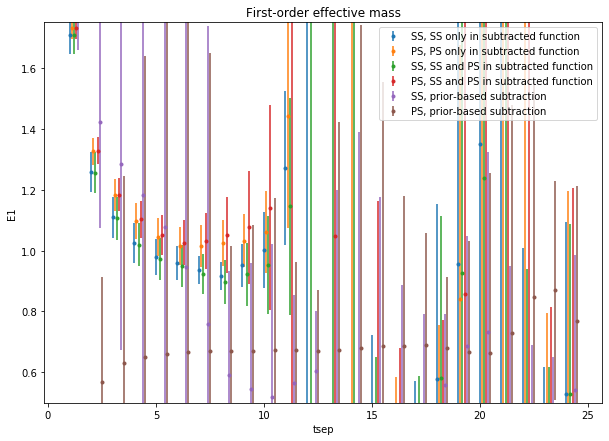

<Figure size 432x288 with 0 Axes>

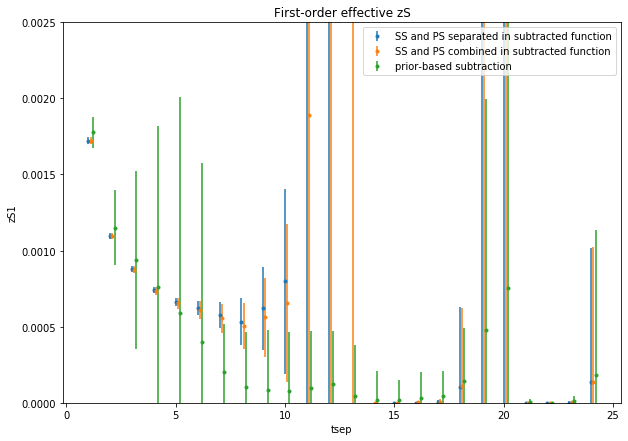

<Figure size 432x288 with 0 Axes>

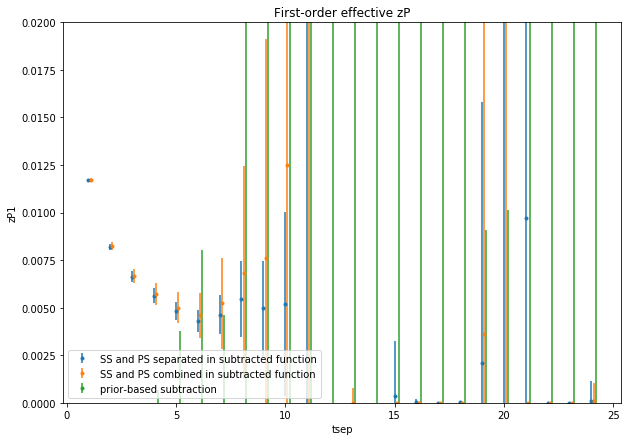

<Figure size 432x288 with 0 Axes>

In [27]:
# Plot E1eff, zS1eff, zP1eff

E1_eff_SS_mean = np.array([gv_avg_data['E1_eff_SS'][i].mean for i in t_plot])
E1_eff_SS_sdev = np.array([gv_avg_data['E1_eff_SS'][i].sdev for i in t_plot])
E1_eff_PS_mean = np.array([gv_avg_data['E1_eff_PS'][i].mean for i in t_plot])
E1_eff_PS_sdev = np.array([gv_avg_data['E1_eff_PS'][i].sdev for i in t_plot])
E1_eff_SS_combined_mean = np.array([gv_avg_data['E1_eff_combined_SS'][i].mean for i in t_plot])
E1_eff_SS_combined_sdev = np.array([gv_avg_data['E1_eff_combined_SS'][i].sdev for i in t_plot])
E1_eff_PS_combined_mean = np.array([gv_avg_data['E1_eff_combined_PS'][i].mean for i in t_plot])
E1_eff_PS_combined_sdev = np.array([gv_avg_data['E1_eff_combined_PS'][i].sdev for i in t_plot])
E1_eff_SS_priorbased_mean = np.array([gv_avg_data['E1_priorbased_SS'][i].mean for i in t_plot])
E1_eff_SS_priorbased_sdev = np.array([gv_avg_data['E1_priorbased_SS'][i].sdev for i in t_plot])
E1_eff_PS_priorbased_mean = np.array([gv_avg_data['E1_priorbased_PS'][i].mean for i in t_plot])
E1_eff_PS_priorbased_sdev = np.array([gv_avg_data['E1_priorbased_SS'][i].sdev for i in t_plot])

meff_labels = np.array(['SS, SS only in subtracted function', 'PS, PS only in subtracted function', 'SS, SS and PS in subtracted function', 'PS, SS and PS in subtracted function', 'SS, prior-based subtraction', 'PS, prior-based subtraction'])
h5_dm.raw_data_plot("First-order effective mass", "tsep", "E1", [t_plot, t_plot+0.1, t_plot+0.2, t_plot+0.3, t_plot+0.4, t_plot+0.5], [E1_eff_SS_mean, E1_eff_PS_mean, E1_eff_SS_combined_mean, E1_eff_PS_combined_mean, E1_eff_SS_priorbased_mean, E1_eff_PS_priorbased_mean], ylim = [0.5, 1.75], nplots = 6, yerror = [E1_eff_SS_sdev, E1_eff_PS_sdev, E1_eff_SS_combined_sdev, E1_eff_PS_combined_sdev, E1_eff_SS_priorbased_sdev, E1_eff_PS_priorbased_sdev], legendlabels = meff_labels, filename="E1eff_9_16.png") # ylim=[0.6, 0.75],

zS1_eff_mean = np.array([gv_avg_data['zS1_eff'][i].mean for i in t_plot])
zS1_eff_sdev = np.array([gv_avg_data['zS1_eff'][i].sdev for i in t_plot])
zP1_eff_mean = np.array([gv_avg_data['zP1_eff'][i].mean for i in t_plot])
zP1_eff_sdev = np.array([gv_avg_data['zP1_eff'][i].sdev for i in t_plot])
zS1_eff_combined_mean = np.array([gv_avg_data['zS1_eff_combined'][i].mean for i in t_plot])
zS1_eff_combined_sdev = np.array([gv_avg_data['zS1_eff_combined'][i].sdev for i in t_plot])
zP1_eff_combined_mean = np.array([gv_avg_data['zP1_eff_combined'][i].mean for i in t_plot])
zP1_eff_combined_sdev = np.array([gv_avg_data['zP1_eff_combined'][i].sdev for i in t_plot])
zS1_eff_priorbased_mean = np.array([gv_avg_data['zS1_priorbased'][i].mean for i in t_plot])
zS1_eff_priorbased_sdev = np.array([gv_avg_data['zS1_priorbased'][i].sdev for i in t_plot])
zP1_eff_priorbased_mean = np.array([gv_avg_data['zP1_priorbased'][i].mean for i in t_plot])
zP1_eff_priorbased_sdev = np.array([gv_avg_data['zP1_priorbased'][i].sdev for i in t_plot])


z_labels = np.array(['SS and PS separated in subtracted function', 'SS and PS combined in subtracted function', 'prior-based subtraction'])
h5_dm.raw_data_plot("First-order effective zS", "tsep", "zS1", [t_plot, t_plot+0.1, t_plot+0.2], [zS1_eff_mean, zS1_eff_combined_mean, zS1_eff_priorbased_mean], ylim=[0, 0.0025], nplots = 3, yerror = [zS1_eff_sdev, zS1_eff_combined_sdev, zS1_eff_priorbased_sdev], legendlabels = z_labels,filename="zS1eff_9_16.png") 
h5_dm.raw_data_plot("First-order effective zP", "tsep", "zP1", [t_plot, t_plot+0.1, t_plot+0.2], [zP1_eff_mean, zP1_eff_combined_mean, zP1_eff_priorbased_mean], ylim=[0, 0.02], nplots = 3, yerror = [zP1_eff_sdev, zP1_eff_combined_sdev, zP1_eff_priorbased_sdev], legendlabels = z_labels, filename="zP1eff_9_16.png") 



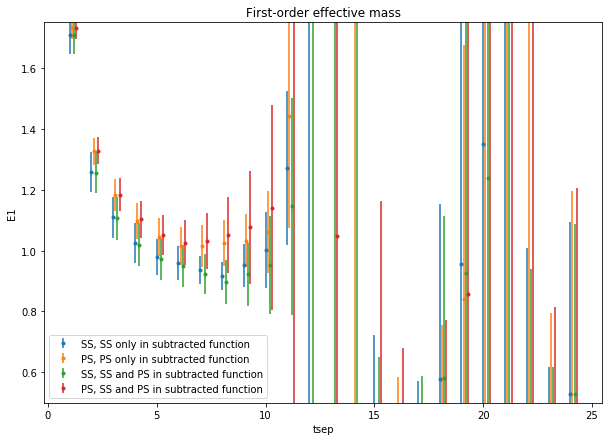

<Figure size 432x288 with 0 Axes>

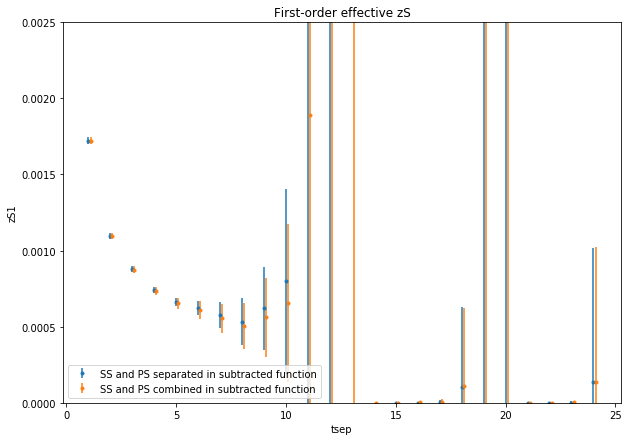

<Figure size 432x288 with 0 Axes>

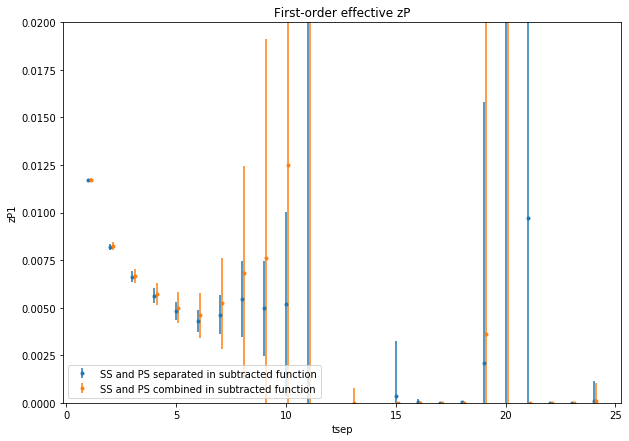

<Figure size 432x288 with 0 Axes>

In [28]:
h5_dm.raw_data_plot("First-order effective mass", "tsep", "E1", [t_plot, t_plot+0.1, t_plot+0.2, t_plot+0.3], [E1_eff_SS_mean, E1_eff_PS_mean, E1_eff_SS_combined_mean, E1_eff_PS_combined_mean], ylim = [0.5, 1.75], nplots = 4, yerror = [E1_eff_SS_sdev, E1_eff_PS_sdev, E1_eff_SS_combined_sdev, E1_eff_PS_combined_sdev], legendlabels = meff_labels, filename="E1eff_9_16_noprior.png") # ylim=[0.6, 0.75],
h5_dm.raw_data_plot("First-order effective zS", "tsep", "zS1", [t_plot, t_plot+0.1], [zS1_eff_mean, zS1_eff_combined_mean], ylim=[0, 0.0025], nplots = 2, yerror = [zS1_eff_sdev, zS1_eff_combined_sdev], legendlabels = z_labels,filename="zS1eff_9_16_noprior.png") 
h5_dm.raw_data_plot("First-order effective zP", "tsep", "zP1", [t_plot, t_plot+0.1], [zP1_eff_mean, zP1_eff_combined_mean], ylim=[0, 0.02], nplots = 2, yerror = [zP1_eff_sdev, zP1_eff_combined_sdev], legendlabels = z_labels, filename="zP1eff_9_16_noprior.png") 

#### Conclusion: the result is too dependent on human input (namely tmin and tmax at each stage for 3 different variables)to really be reliable, at least using this method. One option is to try using Logan's method.

## So, use Logan's method: create a correlation function from just the data that suppresses the ground state

In [29]:

gv_avg_data['D1'] = gv_avg_data['2pt'] - np.roll(gv_avg_data['2pt'], -1, axis = 0)*(np.roll(gv_avg_data['2pt'], -1, axis = 0)/np.roll(gv_avg_data['2pt'], -2, axis = 0))
gv_avg_data['D1_SS'] = gv_avg_data['2pt_SS'] - np.roll(gv_avg_data['2pt_SS'], -1, axis = 0)*(np.roll(gv_avg_data['2pt_SS'], -1, axis = 0)/np.roll(gv_avg_data['2pt_SS'], -2, axis = 0))
gv_avg_data['D1_PS'] = gv_avg_data['2pt_PS'] - np.roll(gv_avg_data['2pt_PS'], -1, axis = 0)*(np.roll(gv_avg_data['2pt_PS'], -1, axis = 0)/np.roll(gv_avg_data['2pt_PS'], -2, axis = 0))

gv_avg_data['logan_E1'] = np.log(gv_avg_data['D1']/np.roll(gv_avg_data['D1'], -1, axis = 0))
gv_avg_data['logan_E1_SS'] = np.log(gv_avg_data['D1_SS']/np.roll(gv_avg_data['D1_SS'], -1, axis = 0))
gv_avg_data['logan_E1_PS'] = np.log(gv_avg_data['D1_PS']/np.roll(gv_avg_data['D1_PS'], -1, axis = 0))

#print(np.shape(np.sqrt(np.array([gv_avg_data['D1_SS'][t]*((gv_avg_data['D1_SS'][t]/gv_avg_data['D1_SS'][t+1])**t )/(1 - ((gv_avg_data['2pt_SS'][t]/gv_avg_data['2pt_SS'][t+1])*(gv_avg_data['D1_SS'][t+1]/gv_avg_data['D1_SS'][t])))  for t in range(len(gv_avg_data['logan_E1_SS'])-1)]))))

gv_avg_data['logan_z1S'] = np.sqrt(np.array([gv_avg_data['D1_SS'][t]*((gv_avg_data['D1_SS'][t]/gv_avg_data['D1_SS'][t+1])**t )/(1 - ((gv_avg_data['2pt_SS'][t]/gv_avg_data['2pt_SS'][t+1])*(gv_avg_data['D1_SS'][t+1]/gv_avg_data['D1_SS'][t])))for t in range(len(gv_avg_data['logan_E1_SS'])-1)]))
gv_avg_data['logan_z1P'] = np.array([gv_avg_data['logan_z1S'][t]*gv_avg_data['D1_PS'][t]/gv_avg_data['D1_SS'][t] for t in range(len(gv_avg_data['logan_z1S']))])

# Now, find the 2nd excited state equivalents 
gv_avg_data['D2'] = gv_avg_data['D1'] - np.roll(gv_avg_data['D1'], -1, axis = 0)*(np.roll(gv_avg_data['D1'], -1, axis = 0)/np.roll(gv_avg_data['D1'], -2, axis = 0))
gv_avg_data['D2_SS'] = gv_avg_data['D1_SS'] - np.roll(gv_avg_data['D1_SS'], -1, axis = 0)*(np.roll(gv_avg_data['D1_SS'], -1, axis = 0)/np.roll(gv_avg_data['D1_SS'], -2, axis = 0))
gv_avg_data['D2_PS'] = gv_avg_data['D1_PS'] - np.roll(gv_avg_data['D1_PS'], -1, axis = 0)*(np.roll(gv_avg_data['D1_PS'], -1, axis = 0)/np.roll(gv_avg_data['D1_PS'], -2, axis = 0))

gv_avg_data['logan_E2'] = np.log(gv_avg_data['D2']/np.roll(gv_avg_data['D2'], -1, axis = 0))
gv_avg_data['logan_E2_SS'] = np.log(gv_avg_data['D2_SS']/np.roll(gv_avg_data['D2_SS'], -1, axis = 0))
gv_avg_data['logan_E2_PS'] = np.log(gv_avg_data['D2_PS']/np.roll(gv_avg_data['D2_PS'], -1, axis = 0))


<ipython-input-29-c7af5257e2ae>:5: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E1'] = np.log(gv_avg_data['D1']/np.roll(gv_avg_data['D1'], -1, axis = 0))
<ipython-input-29-c7af5257e2ae>:6: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E1_SS'] = np.log(gv_avg_data['D1_SS']/np.roll(gv_avg_data['D1_SS'], -1, axis = 0))
<ipython-input-29-c7af5257e2ae>:7: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E1_PS'] = np.log(gv_avg_data['D1_PS']/np.roll(gv_avg_data['D1_PS'], -1, axis = 0))
<ipython-input-29-c7af5257e2ae>:11: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['logan_z1S'] = np.sqrt(np.array([gv_avg_data['D1_SS'][t]*((gv_avg_data['D1_SS'][t]/gv_avg_data['D1_SS'][t+1])**t )/(1 - ((gv_avg_data['2pt_SS'][t]/gv_avg_data['2pt_SS'][t+1])*(gv_avg_data['D1_SS'][t+1]/gv_avg_data['D1_SS'][t])))for t in range(len(gv_avg_data['logan_E1_SS'])-1)]))
<ipython-input-29-c7af5257e2ae>:19: RuntimeWarning: invalid valu

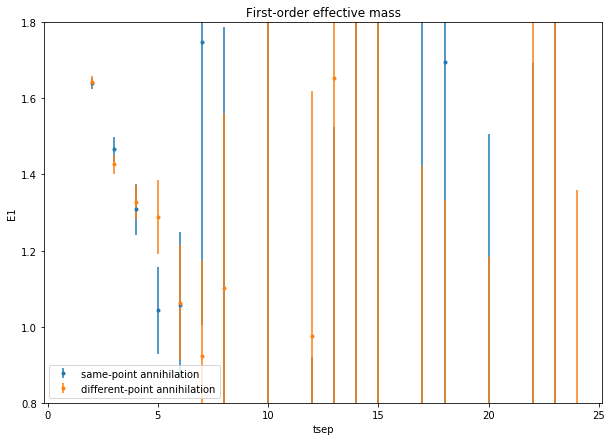

<Figure size 432x288 with 0 Axes>

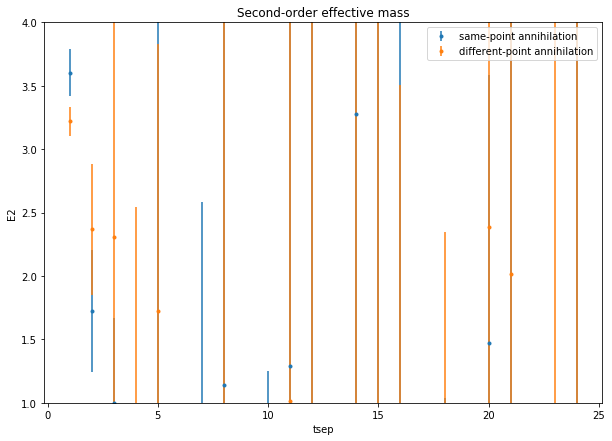

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot the results of Nolan's method
exc_meff_labels = np.array(["same-point annihilation", "different-point annihilation"])

logan_E1_eff_SS_mean = np.array([gv_avg_data['logan_E1_SS'][i].mean for i in t_plot])
logan_E1_eff_SS_sdev = np.array([gv_avg_data['logan_E1_SS'][i].sdev for i in t_plot])
logan_E1_eff_PS_mean = np.array([gv_avg_data['logan_E1_PS'][i].mean for i in t_plot])
logan_E1_eff_PS_sdev = np.array([gv_avg_data['logan_E1_PS'][i].sdev for i in t_plot])

h5_dm.raw_data_plot("First-order effective mass", "tsep", "E1", [t_plot, t_plot], [logan_E1_eff_SS_mean, logan_E1_eff_PS_mean], ylim=[0.8, 1.8], nplots = 2, yerror = [logan_E1_eff_SS_sdev, logan_E1_eff_PS_sdev], legendlabels = exc_meff_labels, filename="E1_nolan.png") #

logan_E2_eff_SS_mean = np.array([gv_avg_data['logan_E2_SS'][i].mean for i in t_plot])
logan_E2_eff_SS_sdev = np.array([gv_avg_data['logan_E2_SS'][i].sdev for i in t_plot])
logan_E2_eff_PS_mean = np.array([gv_avg_data['logan_E2_PS'][i].mean for i in t_plot])
logan_E2_eff_PS_sdev = np.array([gv_avg_data['logan_E2_PS'][i].sdev for i in t_plot])

h5_dm.raw_data_plot("Second-order effective mass", "tsep", "E2", [t_plot, t_plot], [logan_E2_eff_SS_mean, logan_E2_eff_PS_mean], ylim=[1, 4], nplots = 2, yerror = [logan_E2_eff_SS_sdev, logan_E2_eff_PS_sdev], legendlabels = exc_meff_labels, filename="E2_nolan.png") #

### Looks like the error bars in Nolan's method are way too high. The posterior-based method works well up to first order (though with a pretty small flat region). Perhaps a hybrid: the e^(E0) in D(t)'s definition would be found using the posterior method, C(t) using the original correlation function.

In [31]:
# Import the E0 energy-posterior
E0_posterior = gv.gvar(0.664756, 0.00302689)

gv_avg_data['D1_postbased'] = gv_avg_data['2pt'] - np.roll(gv_avg_data['2pt'], -1, axis = 0)*np.exp(E0_posterior)
gv_avg_data['D1_postbased_SS'] = gv_avg_data['2pt_SS'] - np.roll(gv_avg_data['2pt_SS'], -1, axis = 0)*np.exp(E0_posterior)
gv_avg_data['D1_postbased_PS'] = gv_avg_data['2pt_PS'] - np.roll(gv_avg_data['2pt_PS'], -1, axis = 0)*np.exp(E0_posterior)

gv_avg_data['logan_E1_postbased'] = np.log(gv_avg_data['D1_postbased']/np.roll(gv_avg_data['D1_postbased'], -1, axis = 0))
gv_avg_data['logan_E1_postbased_SS'] = np.log(gv_avg_data['D1_postbased_SS']/np.roll(gv_avg_data['D1_postbased_SS'], -1, axis = 0))
gv_avg_data['logan_E1_postbased_PS'] = np.log(gv_avg_data['D1_postbased_PS']/np.roll(gv_avg_data['D1_postbased_PS'], -1, axis = 0))



<ipython-input-31-43eca3956a26>:8: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E1_postbased'] = np.log(gv_avg_data['D1_postbased']/np.roll(gv_avg_data['D1_postbased'], -1, axis = 0))
<ipython-input-31-43eca3956a26>:9: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E1_postbased_SS'] = np.log(gv_avg_data['D1_postbased_SS']/np.roll(gv_avg_data['D1_postbased_SS'], -1, axis = 0))
<ipython-input-31-43eca3956a26>:10: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E1_postbased_PS'] = np.log(gv_avg_data['D1_postbased_PS']/np.roll(gv_avg_data['D1_postbased_PS'], -1, axis = 0))


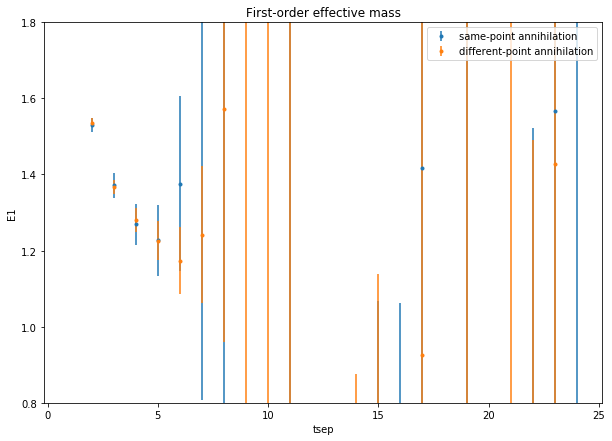

<Figure size 432x288 with 0 Axes>

In [32]:
logan_E1_eff_postbased_SS_mean = np.array([gv_avg_data['logan_E1_postbased_SS'][i].mean for i in t_plot])
logan_E1_eff_postbased_SS_sdev = np.array([gv_avg_data['logan_E1_postbased_SS'][i].sdev for i in t_plot])
logan_E1_eff_postbased_PS_mean = np.array([gv_avg_data['logan_E1_postbased_PS'][i].mean for i in t_plot])
logan_E1_eff_postbased_PS_sdev = np.array([gv_avg_data['logan_E1_postbased_PS'][i].sdev for i in t_plot])

h5_dm.raw_data_plot("First-order effective mass", "tsep", "E1", [t_plot, t_plot], [logan_E1_eff_postbased_SS_mean, logan_E1_eff_postbased_PS_mean], ylim=[0.8, 1.8], nplots = 2, yerror = [logan_E1_eff_postbased_SS_sdev, logan_E1_eff_postbased_PS_sdev], legendlabels = exc_meff_labels, filename="E1_nolan_postbased.png") #

In [37]:
# In order to compute the second excited state with this method, I need to fit D(t)
def D_model(t, p):
    ss = p['z1']*p['z1']*np.exp(-p['E1']*t)*(1-np.exp(p['E0']-p['E1']))
    ps = p['z1']*p['z1tilde']*np.exp(-p['E1']*t)*(1-np.exp(p['E0']-p['E1']))
    
    return np.transpose(np.array([ss, ps]))



In [38]:
hybrid_priors = gv.BufferDict()
hybrid_priors['E0'] = gv.gvar(0.664756, 0.00302689)
hybrid_priors['E1'] = gv.gvar(1.3, 0.2)
hybrid_priors['z1'] = gv.gvar(0.0008, 0.0003)
hybrid_priors['z1tilde'] = gv.gvar(0.003, 0.003)

hybrid_fit = lsqfit.nonlinear_fit(data=(np.array([l for l in range(4,6)]), np.array([gv_avg_data['D1_postbased'][l] for l in range(4,6)])), prior=hybrid_priors,fcn=D_model,debug=True)

print(hybrid_fit.format(pstyle='vv'))

Least Square Fit:
  chi2/dof [dof] = 0.46 [4]    Q = 0.77    logGBF = 80.016

Parameters:
             E0      0.664736 +- 0.00302682            [ 0.664756 +- 0.00302689 ]  
             E1        1.28818 +- 0.0226627            [             1.3 +- 0.2 ]  
             z1   0.00091655 +- 2.16063e-05            [       0.0008 +- 0.0003 ]  
        z1tilde   0.00663787 +- 0.000216322            [         0.003 +- 0.003 ]  *

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 7/0.0)
  fitter = scipy_least_squares    method = trf



In [39]:
# Now, do a calculation for the 2nd excited state
gv_avg_data['D2_postbased'] = gv_avg_data['D1_postbased'] - np.roll(gv_avg_data['D1_postbased'], -1, axis = 0)*np.exp(hybrid_fit.p['E1'])
gv_avg_data['D2_postbased_SS'] = gv_avg_data['D1_postbased_SS'] - np.roll(gv_avg_data['D1_postbased_SS'], -1, axis = 0)*np.exp(hybrid_fit.p['E1'])
gv_avg_data['D2_postbased_PS'] = gv_avg_data['D1_postbased_PS'] - np.roll(gv_avg_data['D1_postbased_PS'], -1, axis = 0)*np.exp(hybrid_fit.p['E1'])

gv_avg_data['logan_E2_postbased'] = np.log(gv_avg_data['D2_postbased']/np.roll(gv_avg_data['D2_postbased'], -1, axis = 0))
gv_avg_data['logan_E2_postbased_SS'] = np.log(gv_avg_data['D2_postbased_SS']/np.roll(gv_avg_data['D2_postbased_SS'], -1, axis = 0))
gv_avg_data['logan_E2_postbased_PS'] = np.log(gv_avg_data['D2_postbased_PS']/np.roll(gv_avg_data['D2_postbased_PS'], -1, axis = 0))



<ipython-input-39-bcd869e57c58>:6: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E2_postbased'] = np.log(gv_avg_data['D2_postbased']/np.roll(gv_avg_data['D2_postbased'], -1, axis = 0))
<ipython-input-39-bcd869e57c58>:7: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E2_postbased_SS'] = np.log(gv_avg_data['D2_postbased_SS']/np.roll(gv_avg_data['D2_postbased_SS'], -1, axis = 0))
<ipython-input-39-bcd869e57c58>:8: RuntimeWarning: invalid value encountered in log
  gv_avg_data['logan_E2_postbased_PS'] = np.log(gv_avg_data['D2_postbased_PS']/np.roll(gv_avg_data['D2_postbased_PS'], -1, axis = 0))


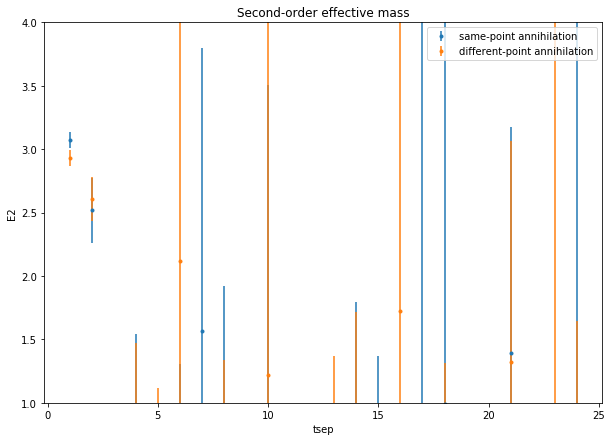

<Figure size 432x288 with 0 Axes>

In [40]:
logan_E2_eff_postbased_SS_mean = np.array([gv_avg_data['logan_E2_postbased_SS'][i].mean for i in t_plot])
logan_E2_eff_postbased_SS_sdev = np.array([gv_avg_data['logan_E2_postbased_SS'][i].sdev for i in t_plot])
logan_E2_eff_postbased_PS_mean = np.array([gv_avg_data['logan_E2_postbased_PS'][i].mean for i in t_plot])
logan_E2_eff_postbased_PS_sdev = np.array([gv_avg_data['logan_E2_postbased_PS'][i].sdev for i in t_plot])

h5_dm.raw_data_plot("Second-order effective mass", "tsep", "E2", [t_plot, t_plot], [logan_E2_eff_postbased_SS_mean, logan_E2_eff_postbased_PS_mean], ylim=[1, 4], nplots = 2, yerror = [logan_E2_eff_postbased_SS_sdev, logan_E2_eff_postbased_PS_sdev], legendlabels = exc_meff_labels, filename="E2_nolan_postbased.png") #